In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')

from utils import scatter_plot
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

# Import Dataset

In [2]:
train = pd.read_csv('./data/SynDepth_train_set.csv', converters={'site_no': str}, low_memory=False)
test = pd.read_csv('./data/SynDepth_test_set.csv', converters={'site_no': str}, low_memory=False)

In [3]:
X_train = train.drop(columns=['site_no', 'mean_depth_va'])
X_test = test.drop(columns=['site_no', 'mean_depth_va'])

y_train = train[['mean_depth_va']]
y_test = test[['mean_depth_va']]

In [8]:
from sklearn.model_selection import GroupShuffleSplit, GroupKFold
# splitter = GroupShuffleSplit(test_size=.125, n_splits=4, random_state=7)
splitter = GroupKFold(n_splits=4)

# Grid Search
param_grid = {'max_depth': range(8, 15, 2),
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': range(1, 8, 2),
              'min_samples_split': [5, 6, 7, 8],
              'n_estimators': [30, 40, 50],
              'bootstrap': [True, False]
              }

rf = RandomForestRegressor(n_jobs=-1, random_state=42)
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=splitter, n_jobs=-1, verbose=True)
# scoring='neg_root_mean_squared_error'

In [9]:
rf_grid.fit(X_train.to_numpy(), y_train.to_numpy().ravel(), groups=train['site_no'])

Fitting 8 folds for each of 768 candidates, totalling 6144 fits


C:\Users\SERFANI\.conda\envs\Geospatial\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


GridSearchCV(cv=GroupKFold(n_splits=8),
             estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': range(8, 15, 2),
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': range(1, 8, 2),
                         'min_samples_split': [5, 6, 7, 8],
                         'n_estimators': [30, 40, 50]},
             verbose=True)

In [10]:
print(rf_grid.best_params_)
print(rf_grid.best_score_)

{'bootstrap': True, 'max_depth': 14, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
0.9554086565084374


In [21]:
import pickle
with open('./data/ml_weights/rf_best_model', "wb") as fp:
    pickle.dump(rf_grid.best_estimator_, fp)

In [44]:
with open('./data/ml_weights/rf_best_model', "rb") as fp:
    rf_grid = pickle.load(fp)

In [19]:
rf_pred = rf_grid.predict(X_test)

C:\Users\SERFANI\.conda\envs\Geospatial\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


NSE: 0.9777, R2: 0.9779, PBias: -0.1491, MSE: 0.9210


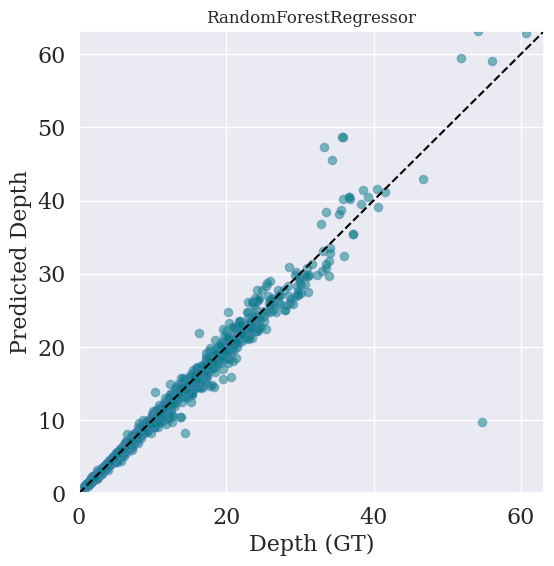

In [20]:
scatter_plot(y_test, rf_pred, model_name='RandomForestRegressor')

In [22]:
from sklearn.inspection import permutation_importance
import time

start_time = time.time()
result = permutation_importance(rf_grid, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

xgb_importances = pd.Series(result.importances_mean, index=X_train.columns)

C:\Users\SERFANI\.conda\envs\Geospatial\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Elapsed time to compute the importances: 5.608 seconds


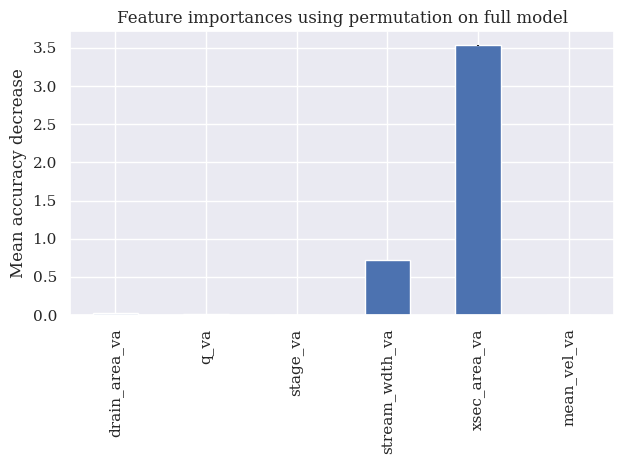

In [23]:
fig, ax = plt.subplots()
xgb_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

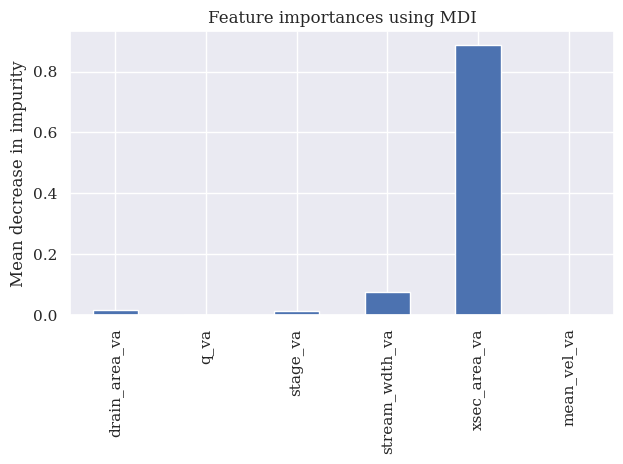

In [25]:
importances = rf_grid.best_estimator_.feature_importances_
std = np.std([rf_grid.best_estimator_.feature_importances_ for tree in rf_grid.best_estimator_.estimators_], axis=0)
xgb_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
xgb_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()